#**IMPORT LIBRARIES**

In [1]:
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
from matplotlib.patches import FancyBboxPatch
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

In [3]:
import calendar

In [4]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import requests
from io import BytesIO

#**GET DATA**

In [ ]:
# Original Google Sheets link
google_sheet_link = "https://docs.google.com/spreadsheets/d/1u9DwSVA4Fc3iCKjTkLDVwvvJbhfGRd5bnRIiv7BjRsY/edit?usp=sharing"

# Modify the link to export as Excel
export_link = google_sheet_link.replace("/edit?usp=sharing", "/export?format=xlsx")

# Read the Excel file into a pandas DataFrame
df = pd.read_excel(export_link)


In [ ]:
df.head()

,order_details_id,order_id,pizza_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,2015-01-01,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,2015-01-01,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,2015-01-01,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


# **1. COLUMN NAMES	DESCRIPTION**


- order_id:	Unique identifier for each order placed by a table

- order_details_id:	Unique identifier for each pizza placed within each order (pizzas of the same type and size are kept in the same row, and the quantity increases)
- pizza_id:	Unique key identifier that ties the pizza ordered to its details, like size and price
quantity	Quantity ordered for each pizza of the same type and size
- order_date:	Date the order was placed (entered into the system prior to cooking & serving)
- order_time:	Time the order was placed (entered into the system prior to cooking & serving)
- unit_price:	Price of the pizza in USD
- total_price:	unit_price * quantity
- pizza_size:	Size of the pizza (Small, Medium, Large, X Large, or XX Large)
- pizza_type:	Unique key identifier that ties the pizza ordered to its details, like size and price
- pizza_ingredients:	Ingredients used in the pizza as shown in the menu (they all include Mozzarella Cheese, even if not specified; and they all include Tomato Sauce, unless another sauce is specified)
- pizza_name:	Name of the pizza as shown in the menu

# **2. AGENDA**

2.1 Business Objective

The business objective of this project is to analyse the sales data from the past year to identify key trends, patterns, and customer preferences. The goal is to use these insights to make data-driven decisions that will help the pizza store optimize its operations, improve marketing strategies, and enhance overall sales for the upcoming year.


2.2 Exploration Questions and Insights

a) Sales Performance Analysis
INSIGHT: Identify key trends and seasonal patterns in sales revenue to optimize inventory and marketing strategies throughout the year.

a1) What is the total sales revenue by month and season? Are there noticeable trends or patterns?

a2) Which five pizza types generate the highest revenue, and what are their key characteristics?

a3) Which pizza sizes are the most popular in terms of revenue and quantity sold? How does size preference impact overall sales?

a4) Which pizzas have the highest quantity sold? What factors contribute to their popularity?

b) Customer Purchase Behavior Analysis

INSIGHT: Understand purchasing habits and preferences to enhance marketing tactics and increase average order value.

b1) What is the average number of pizzas per order? What is the average order value?

b2) What are the most frequently ordered pizza combinations?

b3) How does ordering behavior differ between weekdays and weekends? When are sales peaks and troughs?

b4) How do sales patterns vary by day of the week and time of day? What are the peak sales times?

b5) What has been the monthly quantity sold of vegetarian pizzas over the past year, and how does this compare to the quantity sold of non-vegetarian pizzas during the same period?

c) Pizza Analysis

INSIGHT: Evaluate the performance of different pizza categories to make informed decisions about menu adjustments and inventory management.

c1) What is the revenue and quantity sold for each pizza category?

c2) How does the quantity sold of each category trend throughout the year?

# **3. DATA CLEANING & PREPROCESSING**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   order_details_id   48620 non-null  int64         
 1   order_id           48620 non-null  int64         
 2   pizza_id           48620 non-null  object        
 3   quantity           48620 non-null  int64         
 4   order_date         48620 non-null  datetime64[ns]
 5   order_time         48620 non-null  object        
 6   unit_price         48620 non-null  float64       
 7   total_price        48620 non-null  float64       
 8   pizza_size         48620 non-null  object        
 9   pizza_category     48620 non-null  object        
 10  pizza_ingredients  48620 non-null  object        
 11  pizza_name         48620 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(6)
memory usage: 4.5+ MB


- Dataset contains 12 columns an 48,620 rows
- Data does not contain missing values, all collumns are in correct data type

## SUPLEMENT TIME-BASED INFORMATION

In [ ]:
# prompt: create day of week column and convert day of week to text, For ex: Monday, Tuesday

# Create a new column 'day_of_week' with the day of the week as an integer (0 = Monday, 6 = Sunday)
df['day_of_week'] = pd.to_datetime(df['order_date'] + ' ' + df['order_time']).dt.dayofweek

# Create a mapping dictionary for day of the week to text
day_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

# Map the day of the week to text
df['day_of_week'] = df['day_of_week'].map(day_map)


In [ ]:
# prompt: Categorized order_time into Morning, Lunch, Afternoon, Dinner, and Late Evening.

# Convert 'order_time' to datetime objects
df['order_time'] = pd.to_datetime(df['order_time'], format='%H:%M:%S').dt.time

# Define the time periods
def categorize_time(time):
    if time >= pd.to_datetime('05:00:00').time() and time < pd.to_datetime('10:00:00').time():
        return 'Morning'
    elif time >= pd.to_datetime('10:00:00').time() and time < pd.to_datetime('14:00:00').time():
        return 'Lunch'
    elif time >= pd.to_datetime('14:00:00').time() and time < pd.to_datetime('17:00:00').time():
        return 'Afternoon'
    elif time >= pd.to_datetime('17:00:00').time() and time < pd.to_datetime('21:00:00').time():
        return 'Dinner'
    else:
        return 'Late Evening'


# Apply the function to create a new column 'time_category'
df['time_category'] = df['order_time'].apply(categorize_time)


In [ ]:
# prompt: Classified days as Weekday or Weekend.

# Create a new column 'day_type' to classify days as Weekday or Weekend
df['day_type'] = df['day_of_week'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')


In [ ]:
# prompt: Classified season as Spring, Summer, Fall and Winter.

# Convert 'order_date' to datetime objects
df['order_date'] = pd.to_datetime(df['order_date'])

# Function to classify seasons
def classify_season(date):
    if (date.month >= 3) and (date.month <= 5):
        return 'Spring'
    elif (date.month >= 6) and (date.month <= 8):
        return 'Summer'
    elif (date.month >= 9) and (date.month <= 11):
        return 'Fall'
    else:
        return 'Winter'

# Apply the function to create a new column 'season'
df['season'] = df['order_date'].apply(classify_season)

In [ ]:
df.head()

,order_details_id,order_id,pizza_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,day_of_week,time_category,day_type,season
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,Thursday,Lunch,Weekday,Winter
1,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,Thursday,Lunch,Weekday,Winter
2,3,2,five_cheese_l,1,2015-01-01,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza,Thursday,Lunch,Weekday,Winter
3,4,2,ital_supr_l,1,2015-01-01,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza,Thursday,Lunch,Weekday,Winter
4,5,2,mexicana_m,1,2015-01-01,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,Thursday,Lunch,Weekday,Winter


In [ ]:
df.to_csv('processed_pizza_data.csv')

## CREATE NECESSARY PACKAGES

In [5]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/1oAYslAcLE1sGS0My5qP-d-gqEwZBXpqlopTh7p3eNzw/export?format=csv')

In [6]:
# prompt: convert order date to date time
df['order_date'] = pd.to_datetime(df['order_date'])

In [7]:
# @title Set default color
title_color = "#590004"
main_color = "#fcba04"
second_color = '#a50104'

In [8]:
# @title y_ticks_format function (600000 -> 66k)
def y_ticks_format(value, pos):
    return f'{int(value/1000)}K'

In [9]:
# @title convert month number to name function
def convert_month_number_to_name(df, column_name):
    # Create a dictionary to map month numbers to month names
    month_dict = {i: calendar.month_abbr[i] for i in range(1, 13)}

    # Apply the mapping to the specified column
    df[column_name] = df[column_name].map(month_dict)
    return df

In [47]:
# @title Line graph function
def custom_line_graph(data, title, x_label = '', y_label = '', color = main_color):
  #Uppercase title
  title= title.upper()

  plt.figure(figsize=(10, 7))
  #Draw line graph by seaborn
  sns.lineplot(x = data.columns[0], y = data.columns[1], data = data, color= color, linewidth=2.5, marker = 'o', markersize=10)

  #Remove x and y label (It is contained in title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)

  # Apply the formatter to the y-axis to convert to 'K'
  plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(y_ticks_format))

  #Format size, font, color for x and y ticks
  plt.xticks( fontsize=10, fontweight='roman', color = title_color)
  plt.yticks(fontsize=10, fontweight='roman', color = title_color)

  #Remove tick params
  plt.tick_params(axis='x', which='both', length=0)
  plt.tick_params(axis='y', which='both', length=0)

  #Set title, size, font, color
  plt.title(title, fontsize=14, color=title_color, fontweight='bold')

  # Set the color of the spines
  for spine in plt.gca().spines.values():
    spine.set_edgecolor(title_color)

In [29]:
# @title Bar chart function
def custom_bar_chart(data, title, x_axis = 0,  x_label = '', y_label = '', color = main_color):
  #Uppercase title
  title= title.upper()

  plt.figure(figsize=(10, 7))

  if x_axis == 0:
    y_axis = 1
  else:
    y_axis = 0
  #Draw line graph by seaborn
  sns.barplot(x = data.columns[x_axis], y = data.columns[y_axis], data = data, color= color)

  #Remove x and y label (It is contained in title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)

  if x_axis == 0:
    # Apply the formatter to the y-axis to convert to 'K'
    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(y_ticks_format))
  else:
    plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(y_ticks_format))

  #Format size, font, color for x and y ticks
  plt.xticks( fontsize=10, fontweight='roman', color = title_color)
  plt.yticks(fontsize=10, fontweight='roman', color = title_color)

  #Remove tick params
  plt.tick_params(axis='x', which='both', length=0)
  plt.tick_params(axis='y', which='both', length=0)

  #Set title, size, font, color
  plt.title(title, fontsize=14, color=title_color, fontweight='bold')

  # Set the color of the spines
  for spine in plt.gca().spines.values():
    spine.set_edgecolor(title_color)

In [30]:
# @title Custom charts function
def custom_charts(title, x_axis = 0, x_label = '', y_label = '', color = main_color):

  #Uppercase title
  title= title.upper()
  #Remove x and y label (It is contained in title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)

  if x_axis == 0:
    # Apply the formatter to the y-axis to convert to 'K'
    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(y_ticks_format))
  else:
    plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(y_ticks_format))

  #Format size, font, color for x and y ticks
  plt.xticks( fontsize=10, fontweight='roman', color = title_color)
  plt.yticks(fontsize=10, fontweight='roman', color = title_color)

  #Remove tick params
  plt.tick_params(axis='x', which='both', length=0)
  plt.tick_params(axis='y', which='both', length=0)

  #Set title, size, font, color
  plt.title(title, fontsize=14, color=title_color, fontweight='bold')

  # Set the color of the spines
  for spine in plt.gca().spines.values():
    spine.set_edgecolor(title_color)

  plt.show()

# **4. SALES PERFORMANCE ANALYSIS**

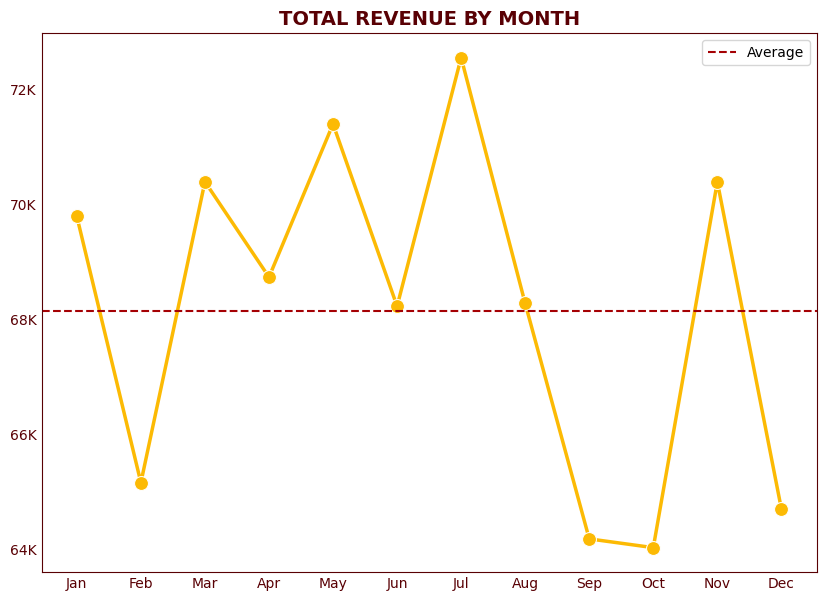

In [48]:
# @title Total sales revenue trend by month
monthly_sales = df.groupby(df['order_date'].dt.month)['total_price'].sum().reset_index()
monthly_sales = convert_month_number_to_name(monthly_sales, monthly_sales.columns[0])
custom_line_graph(data= monthly_sales, title = 'TOTAL REVENUE BY MONTH')
plt.axhline(y=monthly_sales.iloc[:,1].mean(), color=second_color, linestyle='--', label='Average')
#Show legend
plt.legend()
plt.show()

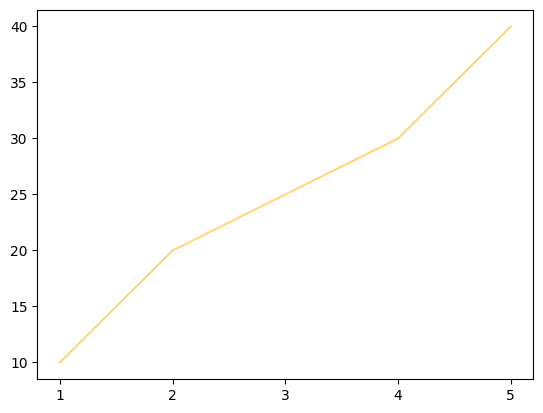

In [50]:
# Sample data
x = [1, 2, 3, 4, 5]
y = [10, 20, 25, 30, 40]

# Plot the data
plt.plot(x, y)

# Reorder x-axis
new_order = [5, 4, 3, 2, 1]  # New order for x-axis
plt.gca().set_xticks(new_order)
plt.gca().set_xticklabels(new_order)

plt.show()

In [60]:
df.groupby('season')['total_price'].sum().reindex(['Spring', 'Summer', 'Fall', 'Winter']).reset_index()

,season,total_price
0,Spring,210536.65
1,Summer,209066.35
2,Fall,198603.00
3,Winter,199654.05


In [56]:
seasonal_revenue = seasonal_revenue.reindex(['Spring', 'Summer', 'Fall', 'Winter'])

In [59]:
seasonal_revenue.reset_index()

,level_0,index,season,total_price
0,0,Spring,NaN,NaN
1,1,Summer,NaN,NaN
2,2,Fall,NaN,NaN
3,3,Winter,NaN,NaN


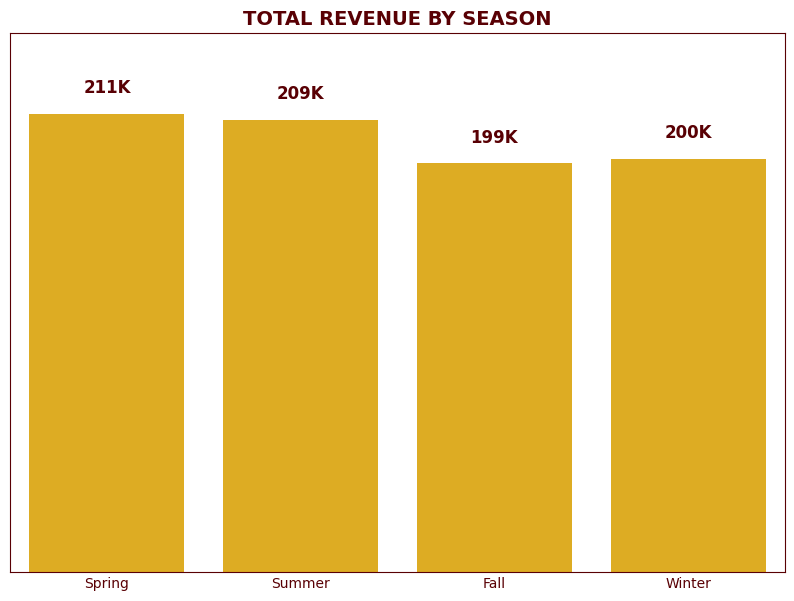

In [61]:
# @title Total sales revenue trend by season
seasonal_revenue = df.groupby('season')['total_price'].sum().reindex(['Spring', 'Summer', 'Fall', 'Winter']).reset_index()
custom_bar_chart(data = seasonal_revenue, title = 'TOTAL REVENUE BY SEASON')

plt.ylim(100000, 230000)
#Hide yticks
plt.tick_params(axis='y', which='both', length=0)
plt.yticks([])

for index, row in seasonal_revenue.iterrows():
    rounded_value = f'{int(round(row.total_price, -3) / 1000)}K'
    plt.text(row.season, row.total_price + 5000, rounded_value, color=title_color, ha="center", fontsize = 12, fontweight='bold')


Monthly Revenue: Revenue varies each month with no clear trend. The highest revenue is in July 72,557.90 and the lowest in October 64,027.60 which is around 13.3% difference.

Seasonal Revenue: Revenue is highest in Spring $210,536.65 and Summer 209,066.35, indicating stronger sales during these warmer seasons. Winter and Fall have lower revenue, showing a seasonal pattern with better performance in warmer months. Overall, warmer months tend to generate higher revenue, but there isn’t a consistent trend throughout the year.

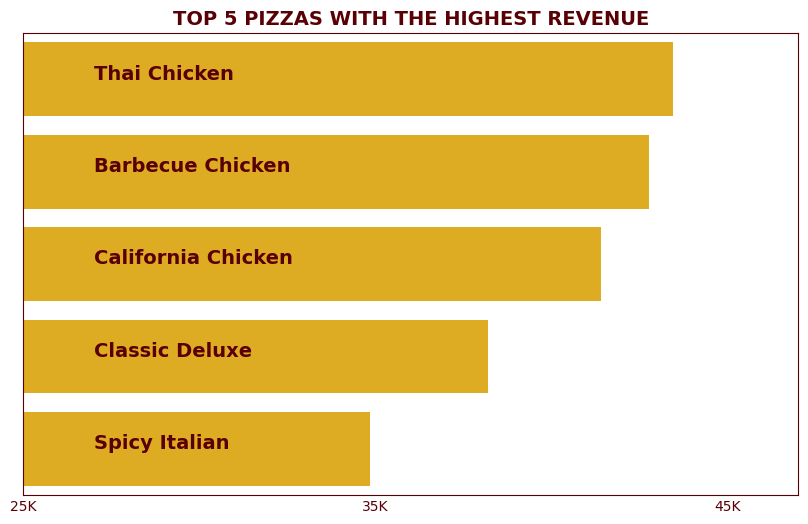

In [44]:
# @title Top 5 pizza types generate the highest revenue
pizza_revenue = df.groupby('pizza_name')['total_price'].sum()

#Find top 5
top_5_pizzas = pizza_revenue.sort_values(ascending=False).head(5).reset_index()
top_5_pizzas['pizza_name'] = top_5_pizzas['pizza_name'].str.replace('The ', '')
top_5_pizzas['pizza_name'] = top_5_pizzas['pizza_name'].str.replace(' Pizza', '')

plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='total_price', y='pizza_name', data=top_5_pizzas, color=main_color)

plt.xlim(25000, 47000)
plt.xticks(range(25000, 47000, 10000))

# Add y-tick values inside each bar
for index, row in top_5_pizzas.iterrows():
    barplot.text(27000, row.pizza_name, row.pizza_name, color=title_color, fontsize = 14, fontweight='bold',horizontalalignment='left')

# Hide y-tick labels
barplot.set_yticklabels([])

#Remove x and y label (It is contained in title)
plt.xlabel('')
plt.ylabel('')

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(y_ticks_format))

#Format size, font, color for x and y ticks
plt.xticks( fontsize=10, fontweight='roman', color = title_color)
plt.yticks(fontsize=10, fontweight='roman', color = title_color)

#Remove tick params
plt.tick_params(axis='x', which='both', length=0)
plt.tick_params(axis='y', which='both', length=0)

#Set title, size, font, color
plt.title('TOP 5 PIZZAS WITH THE HIGHEST REVENUE', fontsize=14, color=title_color, fontweight='bold')

#Set frame color
for spine in barplot.spines.values():
    spine.set_edgecolor(title_color)

plt.show()

**Insight:**

Top-Selling Pizzas: The top three pizzas, which account for approximately 15% of total revenue, are all chicken-based.

Customer Preference: This indicates a strong customer preference for chicken pizzas.

Fusion Flavors: The leading pizza is a fusion flavor, likely popular because it offers something unique and hard to find.

Revenue Concentration: The top 5 pizzas account for about 25% of the total revenue, despite there being 32 different pizza types available. This indicates that this small selection of pizzas significantly drives overall sales

**Hypothesis:**

Flavor Innovation: The popularity of fusion flavors suggests that customers might be drawn to unique and innovative options, which could be a key factor in driving sales.

**Recommendation:**

Explore Ingredients: Investigate the ingredients used in these top-selling pizzas to understand what makes them appealing.

New Pizza Variations: Consider introducing new fusion flavors or variations to capitalize on the existing trend and test the market's response to additional innovative options in the coming year.

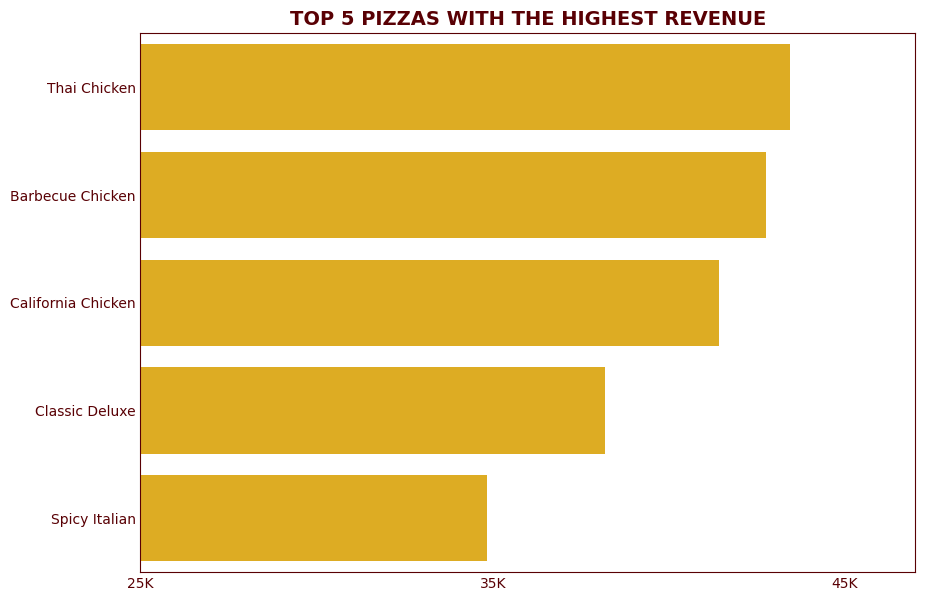

In [33]:
# version 2
#Calculate revenue of each pizza type
pizza_revenue = df.groupby('pizza_name')['total_price'].sum()

#Find top 5
top_5_pizzas = pizza_revenue.sort_values(ascending=False).head(5).reset_index()
top_5_pizzas['pizza_name'] = top_5_pizzas['pizza_name'].str.replace('The ', '')
top_5_pizzas['pizza_name'] = top_5_pizzas['pizza_name'].str.replace(' Pizza', '')

custom_bar_chart(data = top_5_pizzas, title = 'TOP 5 PIZZAS WITH THE HIGHEST REVENUE', x_axis= 1)
plt.xlim(25000, 47000)
plt.xticks(range(25000, 47000, 10000))
plt.show()

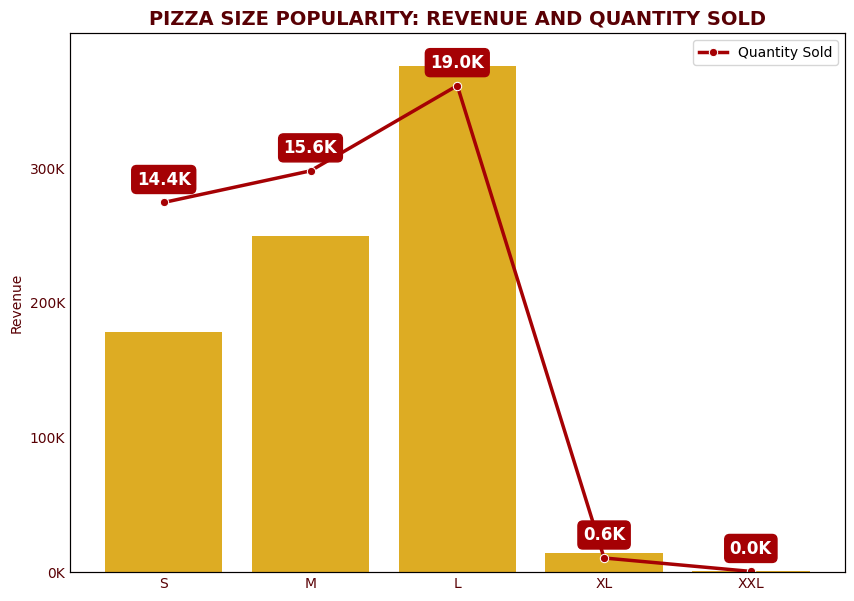

In [34]:
# @title Most popular pizza size in terms of revenue and quantity sold
# Define the order of pizza sizes
size_order = ['S', 'M', 'L', 'XL', 'XXL']
# Group data by pizza_size and sum quantity for quantity sold

size_revenue = df.groupby('pizza_size')['total_price'].sum().reset_index()
size_revenue = size_revenue.set_index('pizza_size').reindex(size_order).reset_index()
size_quantity = df.groupby('pizza_size')['quantity'].sum().reset_index()
size_quantity = size_quantity.set_index('pizza_size').reindex(size_order).reset_index()
custom_bar_chart(data = size_revenue, title = 'Pizza Size Popularity: Revenue and Quantity Sold')
plt.ylim(0, 400000)
plt.yticks(range(0, 400000, 100000))
plt.ylabel('Revenue', color = title_color)
plt.twinx()

sns.lineplot(x='pizza_size', y='quantity', data=size_quantity, color=second_color, linewidth=2.5, marker='o')
plt.ylabel('')
plt.yticks([])
plt.ylim(0, 21000)

props = dict(boxstyle='round', facecolor=second_color,  edgecolor=second_color)
for index, row in size_quantity.iterrows():
    rounded_value = f'{round(row.quantity/ 1000, 1)}K'
    plt.text(row.pizza_size , row.quantity + 700, rounded_value, color='white', ha="center", fontsize = 12, fontweight='bold',  bbox=props)

# Add a legend for the line plot
plt.legend(["Quantity Sold"], loc='upper right' )

plt.show()

**Insight:**

Large Pizza Dominance: The large pizza size is the clear winner, generating the highest revenue and selling the most quantity. This suggests that customers prefer a size that is easy to share, aligning with the social nature of pizza consumption.

Performance of Other Sizes: While medium and small sizes also perform well, there is a sharp decline in both revenue and quantity sold for extra-large and XXL sizes.

**Hypothesis:**

The decline in sales for larger sizes (XL and XXL) might be due to customers' preference for trying a variety of pizzas rather than committing to a single, larger option, which could limit their ability to explore different flavors.

**Next Steps:**

To test this hypothesis, we should analyze whether customers typically purchase more than one pizza per order and prefer multiple flavors. If this is the case, it may confirm that they enjoy sharing different varieties of pizzas, especially in larger groups. This analysis will be explored further in Customer Purchase Behaviour Analysis.

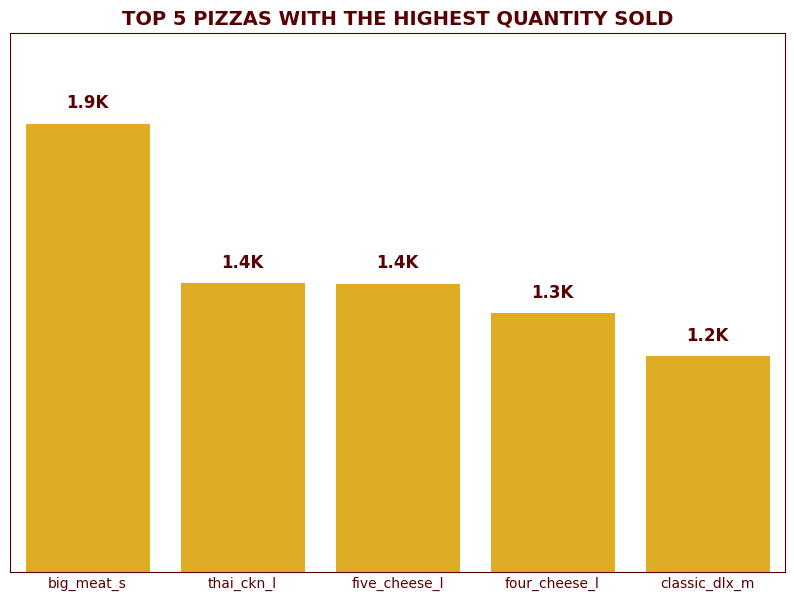

In [35]:
# @title Top 5 pizzas have the highest quantity sold?
# Group data by pizza_name and sum quantity
pizza_quantity = df.groupby('pizza_id')['quantity'].sum()

# Sort the pizza quantity in descending order
top_5_pizzas_quantity = pizza_quantity.sort_values(ascending=False).head(5).reset_index()

custom_bar_chart(data = top_5_pizzas_quantity, title = 'TOP 5 PIZZAS WITH THE HIGHEST QUANTITY SOLD')
plt.ylim(500, 2200)
# #Hide yticks
# plt.tick_params(axis='y', which='both', length=0)
plt.yticks([])

for index, row in top_5_pizzas_quantity.iterrows():
    rounded_value = f'{round(row.quantity/ 1000, 1)}K'
    plt.text(row.pizza_id, row.quantity + 50, rounded_value, color=title_color, ha="center", fontsize = 12, fontweight='bold')


In [ ]:
# prompt: create a dataframe with pizza id, category, unit_price, average price by size, sum quantity of top 5 pizza_id by quantity sold

# Group data by pizza_id and sum quantity
pizza_quantity = df.groupby('pizza_id')['quantity'].sum()

# Sort the pizza quantity in descending order
top_5_pizzas_quantity = pizza_quantity.sort_values(ascending=False).head(5)

# Filter the dataframe to include only the top 5 pizzas by quantity sold
top_5_pizzas_df = df[df['pizza_id'].isin(top_5_pizzas_quantity.index)]

# Group the top 5 pizzas by pizza_id, pizza_category, and pizza_size, then calculate the average unit price and sum of quantity
top_5_summary = top_5_pizzas_df.groupby(['pizza_id', 'pizza_category', 'pizza_size'])['unit_price'].agg(['mean']).reset_index()

# Rename the 'mean' column to 'average_price'
top_5_summary = top_5_summary.rename(columns={'mean': 'average_price'})

# Calculate the sum of quantity for each pizza_id
top_5_summary['total_quantity'] = top_5_pizzas_df.groupby(['pizza_id', 'pizza_category', 'pizza_size'])['quantity'].sum().values

# Display the result
top_5_summary.sort_values(by='total_quantity', ascending=False, inplace= True)

top_5_summary

,pizza_id,pizza_category,pizza_size,average_price,total_quantity
0,big_meat_s,Classic,S,12.00,1914
4,thai_ckn_l,Chicken,L,20.75,1410
2,five_cheese_l,Veggie,L,18.50,1409
3,four_cheese_l,Veggie,L,17.95,1316
1,classic_dlx_m,Classic,M,16.00,1181


**Insight:**

Dominance of Small Classic Pizza: Despite the general trend favoring large pizzas, the "Big Meat" pizza in a small size (S) stands out as the top-seller. This suggests that even though customers prefer larger sizes overall, there is a significant demand for smaller classic pizzas, possibly as an additional or side option.

Emerging Veggie Trend: Two out of the top five best-selling pizzas are vegetarian, indicating that a vegetarian diet may be growing in popularity among customers.

Price vs Quantity Sold: Price is not the primary factor for quantity sold as thai_ckn_l and classic_dlx_m show strong sales, regardless of price.

**Next Step:**

Analyze Pairing Patterns: Investigate whether customers often pair small classic pizzas with other types to validate the pairing preference hypothesis. This can involve examining order combinations to see if small pizzas are frequently ordered with other pizzas. (Analysed in Customer Purchase Behavior Analysis b3)

Track Veggie Trends: Monitor the sales trend of vegetarian pizzas throughout the year to assess whether this reflects a broader shift in dietary preferences. Analyze monthly or quarterly sales data for vegetarian pizzas to determine if the trend is consistent. (Analysed in Customer Purchase Behavior Analysis b5)

# **5. CUSTOMER BEHAVIOUR ANALYSIS**

In [ ]:
# @title Average number of pizzas per order
#calculate average revenue per order
avg_per_order = df.groupby('order_id')['quantity'].sum().reset_index()
print('Average number of pizzas per order', avg_per_order['quantity'].mean())
# Calculate average revenue per order
avg_revenue_per_order = df.groupby('order_id')['total_price'].sum().mean()
print(f"Average revenue per order: {avg_revenue_per_order}")


Average number of pizzas per order 2.321967213114754
Average revenue per order: 38.30726229508196


**Insight:**

Group Ordering: The average of 2.3 pizzas per order supports the idea that orders are typically made by small groups or families.

Order Value: The average order value of $38.31 is unclear without benchmarks. need more data to compare with industry benchmarks, review historical trends, and ensure it supports costs and profitability.

In [ ]:
# @title Top 5 most frequently ordered pizza combinations
# prompt: each order_id might have many pizza_id, help me to find which are top 5 pair of pizza that are ordered together most requently, show 3 columns: pizza 1, pizza 2, frequency

from itertools import combinations

# Create a dictionary to store pizza combinations and their frequencies
pizza_combinations = {}

# Group the dataframe by order_id and pizza_id
orders = df.groupby('order_id')['pizza_id'].apply(list).reset_index()

# Iterate over each order
for index, row in orders.iterrows():
  pizza_list = row['pizza_id']
  # Generate all possible combinations of 2 pizzas within each order
  for combo in combinations(pizza_list, 2):
    # Sort the combination to ensure consistency (e.g., 'pizza1, pizza2' is the same as 'pizza2, pizza1')
    combo = tuple(sorted(combo))
    # Increment the frequency of the combination
    if combo in pizza_combinations:
      pizza_combinations[combo] += 1
    else:
      pizza_combinations[combo] = 1

# Convert the dictionary to a dataframe
combinations_df = pd.DataFrame.from_dict(pizza_combinations, orient='index', columns=['frequency'])
combinations_df.index = pd.MultiIndex.from_tuples(combinations_df.index, names=['pizza_1', 'pizza_2'])
combinations_df = combinations_df.reset_index().sort_values('frequency', ascending=False)

# Sort the dataframe by frequency in descending order
top_5_combinations = combinations_df.head(10)

# Display the top 5 combinations
top_5_combinations


,pizza_1,pizza_2,frequency
866,big_meat_s,thai_ckn_l,144
208,big_meat_s,four_cheese_l,126
61,big_meat_s,five_cheese_l,125
607,big_meat_s,classic_dlx_m,105
203,big_meat_s,spicy_ital_l,104
6,five_cheese_l,thai_ckn_l,98
399,big_meat_s,cali_ckn_l,98
352,big_meat_s,southw_ckn_l,95
421,five_cheese_l,spicy_ital_l,89
680,big_meat_s,hawaiian_s,89


Insight:

Top Pizza Combinations: The top 5 most frequently ordered pizza combinations all include a small big_meat_s pizza paired with larger pizzas, with 4 out of 5 combinations involving a large (L) pizza. This suggests that customers often treat the big_meat_s as a side dish to complement a larger main pizza.

In [ ]:
# prompt: find percentage of combo that contain big_meat_s from table combinations_df

# Calculate the percentage of combinations containing 'big_meat_s'
big_meat_s_count = combinations_df[(combinations_df['pizza_1'] == 'big_meat_s') | (combinations_df['pizza_2'] == 'big_meat_s')].shape[0]
total_combinations = combinations_df.shape[0]
percentage_big_meat_s = (big_meat_s_count / total_combinations) * 100

print(f"Percentage of combinations containing 'big_meat_s': {percentage_big_meat_s:.2f}%")


Percentage of combinations containing 'big_meat_s': 2.25%


In [ ]:
# @title Ordering behavior between weekdays and weekends
#number of days in the whole period
no_days = df[['order_date', 'day_type']].drop_duplicates().groupby('day_type').count().rename(columns={'order_date':'no. days'})
#number of total orders by day-type
day_of_week_order = df[['order_id','day_type']].drop_duplicates().groupby('day_type').count().rename(columns={'order_id':'no. total orders'})

#calulate average of quantity per order by day type
day_of_week_revenue = df.groupby('day_type')['total_price'].sum()
avg_quantity_per_order_by_day_type = df.groupby(['day_type', 'order_id'])['quantity'].sum().groupby('day_type').mean().rename('Average quantity per order')

# Concat the three tables
day_type_behavior = pd.concat([no_days, day_of_week_order, day_of_week_revenue, avg_quantity_per_order_by_day_type], axis=1)
day_type_behavior['Average order per day'] = day_type_behavior['no. total orders'] / day_type_behavior['no. days']
day_type_behavior['Average revenue per day'] = day_type_behavior['total_price'] / day_type_behavior['no. days']

day_type_behavior

,no. days,no. total orders,total_price,Average quantity per order,Average order per day,Average revenue per day
day_type,,,,,,
Weekday,254,15568,595474.15,2.315391,61.291339,2344.386417
Weekend,104,5782,222385.90,2.339675,55.596154,2138.325962


**Insights:**

Weekday vs. Weekend Orders: The average number of orders per day is  **10.23%** higher on weekdays than on weekends, likely due to routine or work-related convenience. Additionally, revenue per day is also **9.63%** higher on weekdays, indicating that the value of each order is similar across both day categories.

In [ ]:
# prompt: plot clustered bar chart that left y-axis is average order per day, right y-axis is average revenue per day, and x-axis is average order per day and average revenue per day, legend is day type, adjust the position of each column, dont let it overlap

# Create a figure and axes
# fig, ax1 = plt.subplots(figsize=(10, 6))

# # Plot the average order per day as a bar chart
# width = 0.35
# x = [0, 1]  # Positions for the bars
# ax1.bar(x, day_type_behavior['Average order per day'], width, color=['blue', 'green'], label='Average order per day')
# ax1.set_xlabel('Day Type')
# ax1.set_ylabel('Average Order per Day', color='blue')
# ax1.tick_params(axis='y', labelcolor='blue')

# # Create a second y-axis for average revenue per day
# ax2 = ax1.twinx()

# # Plot the average revenue per day as a bar chart
# ax2.bar([i + width for i in x], day_type_behavior['Average revenue per day'], width, color=['red', 'orange'], label='Average revenue per day')
# ax2.set_ylabel('Average Revenue per Day', color='green')
# ax2.tick_params(axis='y', labelcolor='green')

# # Set x-axis labels
# ax1.set_xticks([i + width / 2 for i in x])
# ax1.set_xticklabels(['Weekday', 'Weekend'])

# # Combine legends
# lines, labels = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# # Set title
# plt.title('Average Order per Day and Average Revenue per Day by Day Type')

# # Adjust the position of the bars
# plt.tight_layout()

# # Show the plot
# plt.show()


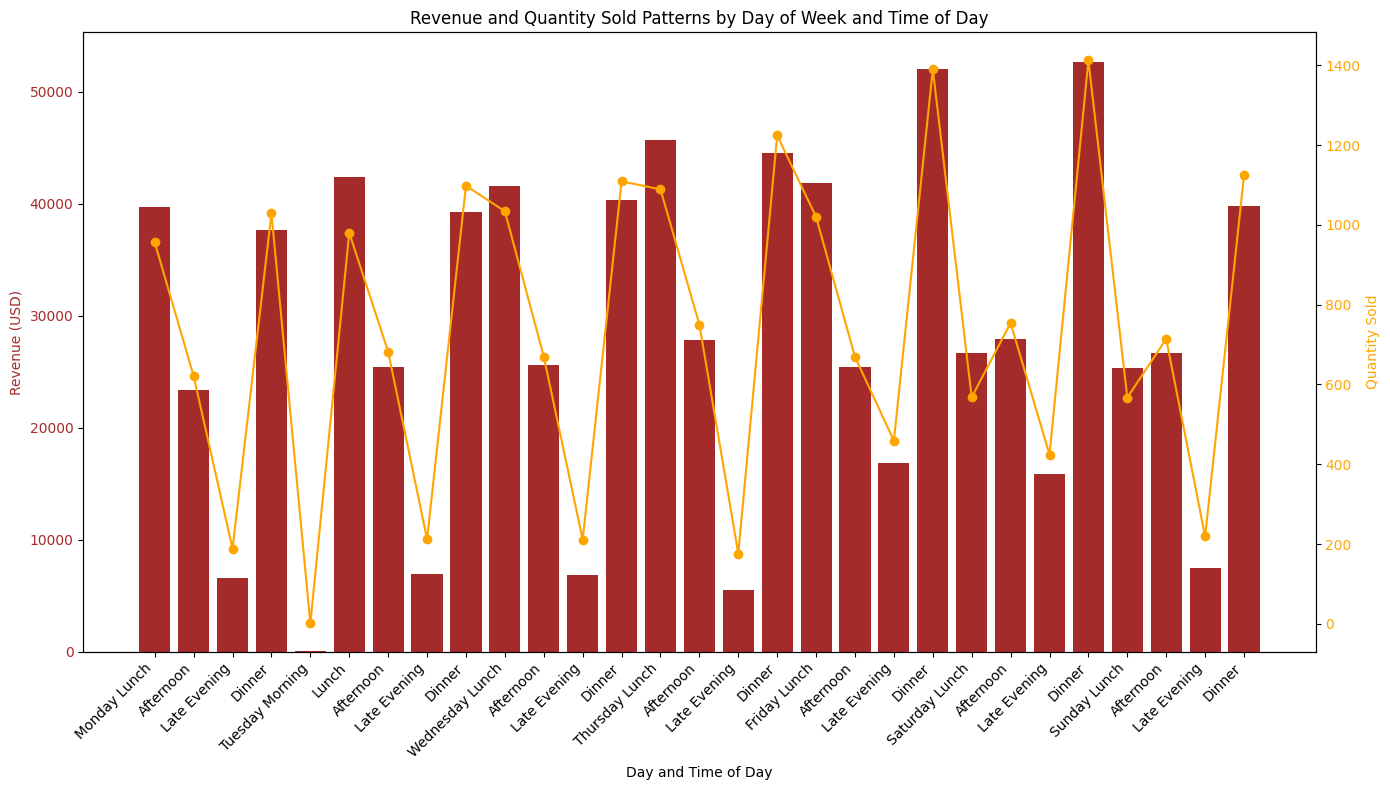

In [ ]:
# @title Sales patterns by day of the week and time of day
sale_pattern = df.groupby(['day_of_week', 'time_category']).agg({'order_id' : 'nunique', 'total_price': 'sum'}).rename(columns={'order_id': 'total_orders', 'total_price' : 'total_revenue'})
sale_pattern['avg_revenue_per_order'] = sale_pattern['total_revenue'] / sale_pattern['total_orders']
sale_pattern.reset_index(inplace=True)
sale_pattern.dropna(inplace = True)
# Specify the custom order for 'day_of_week' and 'time_category'
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
time_order = ['Morning', 'Lunch', 'Afternoon', 'Late Evening', 'Dinner']

# Convert both columns to Categorical data types with the specified order
sale_pattern['day_of_week'] = pd.Categorical(sale_pattern['day_of_week'], categories=day_order, ordered=True)
sale_pattern['time_category'] = pd.Categorical(sale_pattern['time_category'], categories=time_order, ordered=True)

# Sort the DataFrame based on 'day_of_week' and 'time_category'
sale_pattern = sale_pattern.sort_values(by=['day_of_week', 'time_category'])

sale_pattern['day_of_week'] = sale_pattern['day_of_week'].astype('str')
sale_pattern['time_category'] = sale_pattern['time_category'].astype('str')

# Set up the figure and axes
fig, ax1 = plt.subplots(figsize=(14, 8))

# Create the x-tick positions
x_labels = sale_pattern['day_of_week'] + " " + sale_pattern['time_category']
x_pos = np.arange(len(x_labels))  # Position for each x-tick

# Plot the total revenue as bars
ax1.bar(x_pos, sale_pattern['total_revenue'], color='brown', label='Total Revenue (USD)')

# Label the first y-axis (Revenue) and the x-axis
ax1.set_ylabel('Revenue (USD)', color='brown')
ax1.set_xlabel('Day and Time of Day')
ax1.tick_params(axis='y', labelcolor='brown')

# Custom x-tick labels
new_labels = []
prev_day = None

for day, time in zip(sale_pattern['day_of_week'], sale_pattern['time_category']):
    if day != prev_day:
        new_labels.append(day + " " + time)  # Show day and time on the first occurrence
        prev_day = day
    else:
        new_labels.append(time)  # Only show the time for subsequent occurrences of the day

# Set x-ticks with the custom labels
ax1.set_xticks(x_pos)
ax1.set_xticklabels(new_labels, rotation=45, ha='right')

# Create a second y-axis to plot the total orders
ax2 = ax1.twinx()
ax2.plot(x_pos, sale_pattern['total_orders'], color='orange', label='Total Orders (Quantity Sold)', marker='o')

# Label the second y-axis (Orders)
ax2.set_ylabel('Quantity Sold', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add a title
plt.title('Revenue and Quantity Sold Patterns by Day of Week and Time of Day')

# Display the plot
plt.tight_layout()
plt.show()

**Insight:**

Peak Sales Times: The highest sales are on Friday and Saturday during dinner, with both the most revenue and the highest quantity sold. On the other hand, Thursday evening has the lowest sales figures.

Order Value Patterns: The revenue per order tends to be higher during lunch and dinner hours, as seen from the revenue bars being taller than the quantity sold line. This suggests that while lunch orders are high, they also bring in higher revenue compared to other times of day.

Customer Buying Behavior: Customers mostly order pizza for lunch and dinner, not for breakfast or late at night. This suggests that pizza is a popular choice for mid-day and evening meals, especially on spare days (Fri and Sat).

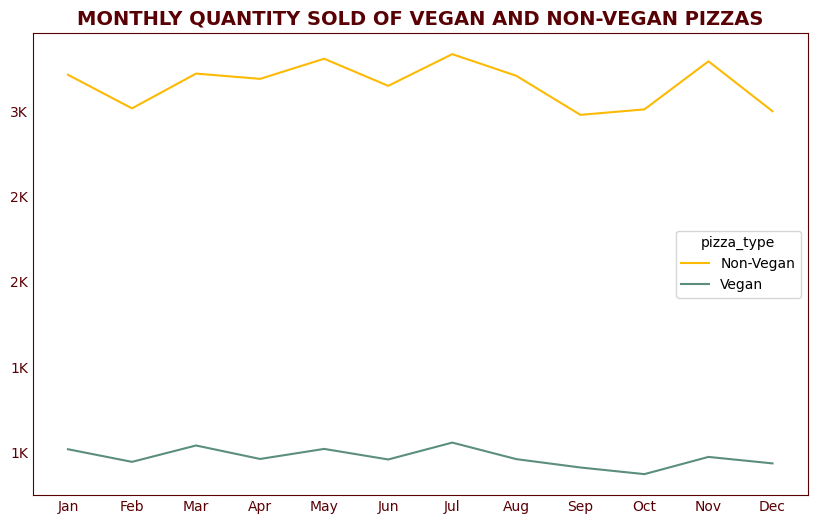

In [36]:
# @title Monthly quantity sold of vegetarian pizzas
# Extract month from order_date
df['month'] = pd.to_datetime(df['order_date']).dt.month

# Create a new column to identify vegan and non-vegan pizzas
df['pizza_type'] = np.where(df['pizza_category'] == 'Veggie', 'Vegan', 'Non-Vegan')

# Group by month and pizza_type, then sum the quantity
monthly_quantity = df.groupby(['month', 'pizza_type'])['quantity'].sum().reset_index()
convert_month_number_to_name(monthly_quantity, 'month')

# Create a multi-line plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='month', y='quantity', hue='pizza_type', data=monthly_quantity, palette = [main_color, '#5b8e7d'])
custom_charts(title = 'Monthly Quantity Sold of Vegan and Non-Vegan Pizzas'.upper())

plt.show()


**Insight:**

Steady Preferences: Sales for both veggie and non-veggie pizzas have been steady throughout the year, with only small ups and downs. This suggests that customer preferences haven't changed much, and there's no clear increase in demand for vegetarian pizzas. However, it's worth keeping an eye on this in case customer preferences shift in the future.

**Conclusion:**

While the current data doesn’t support a growing trend for vegetarian pizzas. It’s a good idea to regularly review this data to catch any changes in consumer behavior or the impact of marketing efforts.

# **6. PIZZAS ANALYSIS**

###Revenue and quantity sold for each pizza category

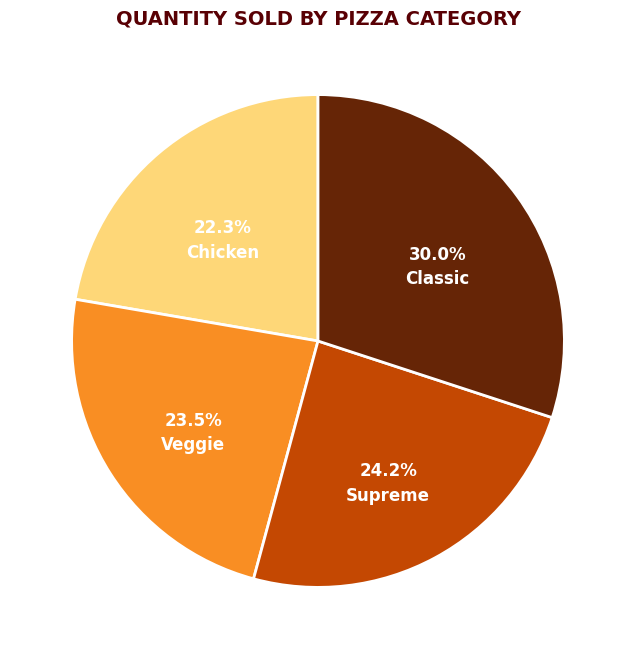

In [ ]:
# @title Quantity sold for each pizza category
# Calculate the quantity sold for each pizza category and sort in descending order
category_quantity = df.groupby('pizza_category')['quantity'].sum().sort_values(ascending=True)

colors = plt.cm.YlOrBr(np.linspace(0.3, 1, len(category_quantity)))
wedgeprops = {'edgecolor': 'white', 'linewidth': 2}
# Custom function to format the percentage labels
def autopct_format(pct):
    return f'{pct:.1f}%'

# Create a pie chart
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(category_quantity, autopct=autopct_format, startangle=90, colors=colors, wedgeprops=wedgeprops)

# Customize the appearance of the percentage labels
for i, autotext in enumerate(autotexts):
    # Add category label below the percentage
    plt.text(autotext.get_position()[0], autotext.get_position()[1] - 0.1, category_quantity.index[i], ha='center', va='center', fontsize=12, color='white', fontweight = 'bold')
    autotext.set_color('white')
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')

plt.title('Quantity Sold by Pizza Category'.upper(), fontsize=14, color=title_color, fontweight='bold' )
plt.show()

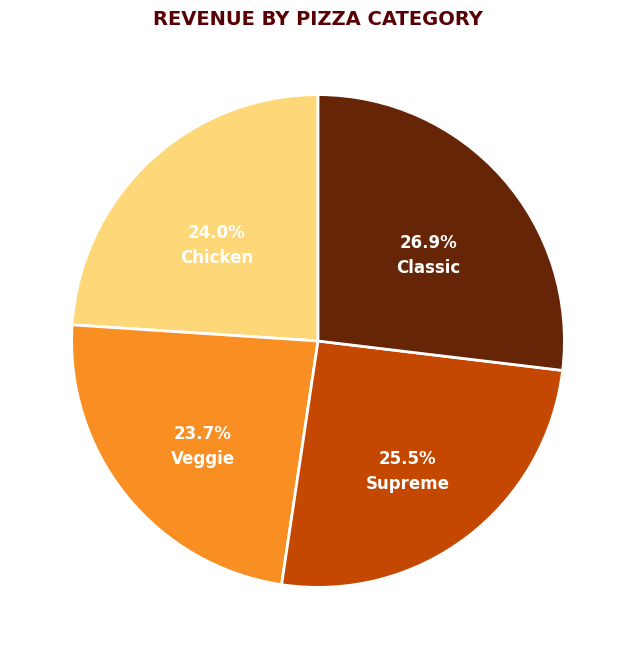

In [ ]:
# @title Revenue for each pizza category
# Calculate the revenue sold for each pizza category
category_rev = df.groupby('pizza_category')['total_price'].sum()

# Reindex the revenue data to match the order of category_quantity
category_rev = category_rev.reindex(category_quantity.index)

# Create a pie chart
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(category_rev, autopct=autopct_format, startangle=90, colors=colors, wedgeprops=wedgeprops)

# Customize the appearance of the percentage labels
for i, autotext in enumerate(autotexts):
    # Add category label below the percentage
    plt.text(autotext.get_position()[0], autotext.get_position()[1] - 0.1, category_rev.index[i], ha='center', va='center', fontsize=12, color='white', fontweight = 'bold')
    autotext.set_color('white')
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')

plt.title('revenue by Pizza Category'.upper(), fontsize=14, color=title_color, fontweight='bold' )
plt.show()


**Insight:**

Chicken Pizzas’ Revenue Performance: Chicken pizzas generate strong revenue but only contribute 24% of total revenue. The Classic category leads in revenue (26.9%) and quantity sold (30%). However, Classic pizzas are less effective in revenue per unit sold compared to Chicken pizzas.

Revenue Efficiency: Chicken pizzas are more revenue-efficient, generating nearly as much revenue as Classic pizzas with fewer units sold (26.91% revenue vs. 23.96% on 30.03% quantity vs. 22.29%). This suggests Chicken pizzas have a higher average revenue, making them more profitable per pizza. Plus, Chicken pizzas are often preferred in larger sizes, which boosts their revenue efficiency, while Classic pizzas are more frequently ordered in smaller sizes.

Even Distribution Across All Categories: The revenue and quantity distribution across the pizza categories are relatively even, suggesting a balanced customer preference. This balance indicates that no single category overwhelmingly dominates sales.

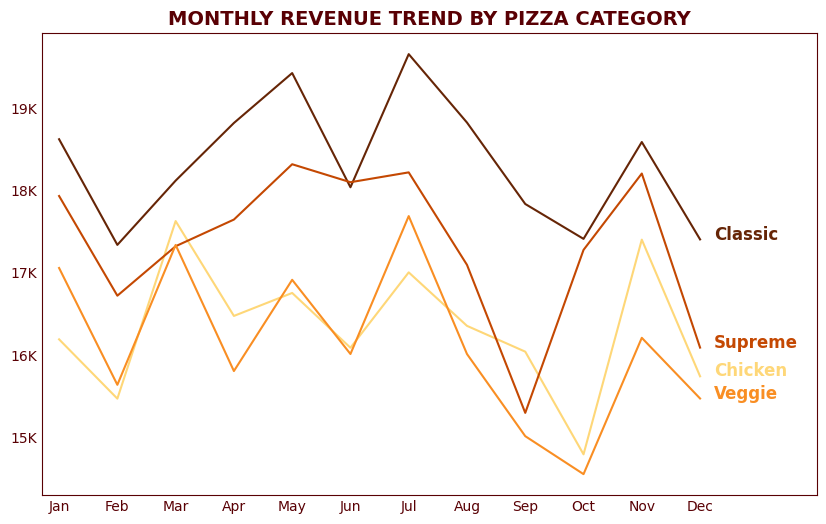

<Figure size 640x480 with 0 Axes>

In [37]:
# @title Quantity sold of each category trend throughout the year
# Calculate the quantity sold for each pizza category and sort in descending order
category_quantity = df.groupby('pizza_category')['quantity'].sum().sort_values(ascending=True)

# Define the colors used in the pie charts
colors = plt.cm.YlOrBr(np.linspace(0.3, 1, len(category_quantity)))

# Create a dictionary to map pizza categories to colors
color_dict = {category: color for category, color in zip(category_quantity.index, colors)}

# Group by month and pizza_category, then sum the total_price
monthly_revenue = df.groupby(['month', 'pizza_category'])['total_price'].sum().reset_index()
convert_month_number_to_name(monthly_revenue, 'month')
monthly_revenue

# Set the color palette for the line plot
sns.set_palette([color_dict[category] for category in monthly_revenue['pizza_category'].unique()])

# Create a multi-line plot
plt.figure(figsize=(10, 6))
ax = sns.lineplot(x='month', y='total_price', hue='pizza_category', data=monthly_revenue, legend=False)

# Annotate the end of each line with the category label
for category in category_quantity.index:
    last_month = monthly_revenue[monthly_revenue['pizza_category'] == category]['month'].iloc[-1]
    last_value = monthly_revenue[monthly_revenue['pizza_category'] == category]['total_price'].iloc[-1]
    ax.annotate(category, xy=(last_month, last_value), xytext=(10, 0), textcoords='offset points', color=color_dict[category], fontsize=12, fontweight='bold', ha='left')

# Set x-axis limits to provide more space for labels
plt.xlim(-0.3,len(monthly_revenue['month'].unique() ) + 1)
custom_charts(title = 'Monthly Revenue Trend by Pizza Category'.upper())
plt.tight_layout()
plt.show()


**Insight:**

Sales Peak in July: July marks the peak of sales across all pizza categories, with a total of 4,392 units sold, indicating a possible seasonal demand or promotion during this month.

Consistent Sales Drop from August to October: Sales consistently decline from August to October across all categories, suggesting a possible seasonal trend or external factors affecting overall demand during these months.

Uniform Category Behavior: All pizza categories exhibit a synchronized trend, with no one category experiencing significant gains or losses relative to the others. This uniformity suggests that external factors influencing demand impact all pizza categories equally.

# **7. CONCLUSION**



**1. Sales Performance Overview**

Sales Performance Over Time: Revenue and order quantities remain relatively stable throughout the year, with warmer months outperforming colder ones. Peak sales occur in July 72,557.90, while the lowest sales are in October 64,027.60, reflecting a 13.3% difference. This suggests the need to adjust inventory levels to match demand, ensuring sufficient stock during peak periods and minimising wastage during low seasons. Additionally, strategies should be developed to retain customers during off-peak seasons.

Category Performance: Revenue distribution across categories is relatively even, though the Classic category leads with $220k, driven by high sales volume. However, to align with our business objectives, we should prioritise promoting Chicken and Supreme category pizzas due to their high demand and revenue efficiency.

**2. Revenue Insights**

High Revenue Efficiency: Chicken pizzas demonstrate the highest revenue efficiency, attributed to their higher average price and the popularity of the large size among customers.

Top Revenue Drivers by Pizza Type: The top 5 pizza types account for nearly a quarter of total revenue, with 3 of these being from the Chicken category. Exploring additional chicken-based recipes could further capitalise on this trend.

**3. Customer Behaviour and Preferences**

Higher Sales on Weekdays: The average number of orders per day is 9.5% higher on weekdays compared to weekends, likely due to routine or work-related convenience. Revenue per day is also 9.5% higher on weekdays, suggesting that order values are consistent across both day categories. Implementing promotions on weekends could encourage more customers to order pizzas during this time.

Higher Sales Between Lunch and Dinner: Lunch drives the highest sales, especially on weekdays, with higher revenue efficiency during this period. In contrast, breakfast and supper sales are minimal, indicating that customers do not view pizza as a snack or small meal. Expanding the menu to cater to customer preferences during these timeframes could boost sales.

Fusion Flavour Pizza Popularity: The Thai Chicken Pizza is the top flavour in terms of revenue, with its large size ranking as the second most sold pizza. Despite not being the cheapest option, customers are willing to pay a premium for special or fusion flavours. We should experiment with more fusion flavours and collect data to test market preferences.

Small Size Big Meat Pizza as a Best Seller: The top 5 pizza combos all include a small-size Big Meat Pizza, indicating that customers frequently order it as a side. Adjusting the menu to highlight small pizza options could encourage more customers to follow this pattern.

# **8. RECOMMENDATION**



Optimise Product Offerings: Focus on high-revenue, high-efficiency categories, such as Chicken pizzas. For Example, refine the menu to position Chicken pizzas in areas where they will be more frequently noticed by customers.

Combo Upsells: Utilise pairing data to create combo deals that combine large-sized pizzas with small-sized Classic pizzas, adding sides or drinks to upsell customers.

Seasonal Product Offerings: Introduce seasonal menu items that align with customer preferences throughout the year. For example, lighter, fresher options in the summer and heartier, comfort-food pizzas in the colder months could resonate with customers and boost sales.

Boost Non-Peak Hour Sales: Launch bite-sized products for supper and breakfast-inspired pizzas for morning sales. Test these offerings with limited-time promotions to gauge market response, and consider regular pizza promotions during these periods to increase sales.

Release More Fusion Pizzas: Given the success of the Thai Chicken Pizza, introduce more fusion flavours with limited-time promotions, as customers may be less price-sensitive to these unique offerings.

Increase Weekend Sales: Implement promotions or loyalty programs to boost weekend sales, such as offering free drinks or snacks on orders over a certain value, or doubling points earned on weekend purchases.

Staffing Optimisation: Adjust staffing levels based on sales patterns, increasing crew during peak times to optimise labor costs relative to revenue. During peak months like July, consider hiring part-time staff to manage demand without increasing fixed costs.

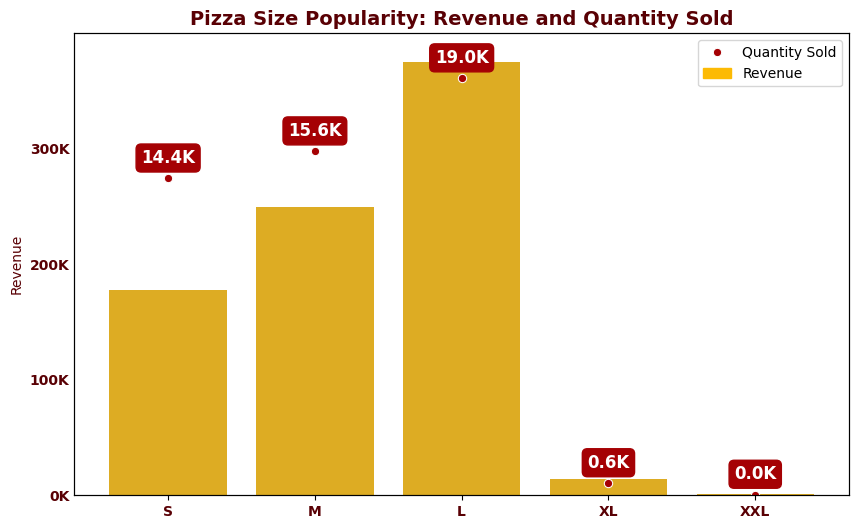

In [ ]:
# @title (draft) Most popular pizza size in terms of revenue and quantity sold
# Define the order of pizza sizes
size_order = ['S', 'M', 'L', 'XL', 'XXL']

# Group data by pizza_size and sum total_price for revenue
size_revenue = df.groupby('pizza_size')['total_price'].sum().reset_index()
size_revenue = size_revenue.set_index('pizza_size').reindex(size_order).reset_index()

# Group data by pizza_size and sum quantity for quantity sold
size_quantity = df.groupby('pizza_size')['quantity'].sum().reset_index()
size_quantity = size_quantity.set_index('pizza_size').reindex(size_order).reset_index()

# Create a figure and axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the quantity sold as a bar chart
sns.barplot(x='pizza_size', y='total_price', data=size_revenue, order=size_order, ax=ax1, color="#fcba04")
ax1.set_xlabel('')
ax1.set_ylabel('Revenue', color=title_color)
ax1.tick_params(axis='y', length=0)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(y_ticks_format))
plt.xticks(fontsize=10, fontweight='bold', color=title_color)
plt.yticks(fontsize=10, fontweight='bold', color=title_color)
plt.ylim(0, 400000)
plt.yticks(range(0, 400000, 100000))

# Create a second y-axis for quantity sold
ax2 = ax1.twinx()

# Plot the revenue as a line graph with transparent line and red points
sns.lineplot(x='pizza_size', y='quantity', data=size_quantity, color=second_color, linewidth=0, marker='o', ax=ax2, label='Quantity Sold')
ax2.set_ylabel('')
ax2.tick_params(axis='y', length=0)
plt.yticks([])
plt.ylim(0, 21000)

# Add text annotations
props = dict(boxstyle='round', facecolor=second_color,  edgecolor=second_color)
for index, row in size_quantity.iterrows():
    rounded_value = f'{round(row.quantity/ 1000, 1)}K'
    plt.text(row.pizza_size , row.quantity + 700, rounded_value, color='white', ha="center", fontsize = 12, fontweight='bold',  bbox=props)

# Set title
plt.title('Pizza Size Popularity: Revenue and Quantity Sold', fontsize=14, color=title_color, fontweight='bold')

# access legend objects automatically created from data
handles, labels = plt.gca().get_legend_handles_labels()

# create manual legend for revenue
patch = mpatches.Patch(color=main_color, label='Revenue')

# add manual legend for revenue
handles.extend([patch])
plt.legend(handles=handles)


plt.show()
